In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import random
from torchsummary import summary

In [2]:
seed = 26
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def seed_worker(worker_id):
    worker_seed = 26
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(26)

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

In [8]:
batch_size = 32

kwargs = {'batch_size': batch_size, 'shuffle': False, 'worker_init_fn': seed_worker, 'pin_memory': True, 'generator':g}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

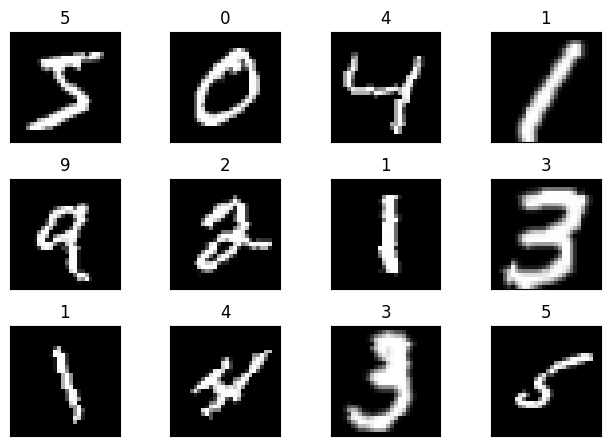

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [10]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv6 = nn.Conv2d(32, 8, kernel_size=1)
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(81*16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [14]:
model = Net().to(device)
tot_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        tot_params+=param.numel()
        print(f"{name}: {param.numel()} parameters")


conv1.weight: 72 parameters
conv1.bias: 8 parameters
conv2.weight: 1152 parameters
conv2.bias: 16 parameters
conv3.weight: 4608 parameters
conv3.bias: 32 parameters
conv6.weight: 256 parameters
conv6.bias: 8 parameters
conv5.weight: 1152 parameters
conv5.bias: 16 parameters
fc1.weight: 12960 parameters
fc1.bias: 10 parameters


In [15]:
print(tot_params)

20290


In [16]:
summary(model,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 24, 24]           1,168
            Conv2d-3           [-1, 32, 22, 22]           4,640
            Conv2d-4            [-1, 8, 11, 11]             264
            Conv2d-5             [-1, 16, 9, 9]           1,168
            Linear-6                   [-1, 10]          12,970
Total params: 20,290
Trainable params: 20,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.08
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [17]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [18]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

criterion = nn.CrossEntropyLoss(reduction="mean")

num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.1287 Batch_id=1874 Accuracy=91.66: 100%|██████████| 1875/1875 [00:32<00:00, 57.18it/s]


Test set: Average loss: 0.0049, Accuracy: 9568/10000 (95.68%)



In [21]:
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")